<a href="https://colab.research.google.com/github/CescaNeri/ML-stocks-prediction/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 22.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
%pip install finta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from finta import TA

In [ ]:
stock = 'NVDA'

nvidia = yf.Ticker(stock)
nvidia = nvidia.history(period='max')

nvidia

In [11]:
bitcoin = yf.Ticker('BTC')
bitcoin = bitcoin.history(period='max')

In [ ]:
bitcoin

In [26]:
intel = yf.Ticker('INTC')
intel = intel.history(period = 'max')

In [27]:
print(len(intel))

10767


In [20]:
intel

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-10-25 00:00:00-04:00,26.817798,27.192734,26.640197,27.044733,32205300,0.000,0
2022-10-26 00:00:00-04:00,26.827665,27.429535,26.630329,26.847397,37111100,0.000,0
2022-10-27 00:00:00-04:00,27.084201,27.222335,25.781790,25.919926,56305100,0.000,0
2022-10-28 00:00:00-04:00,27.804472,28.830612,27.488737,28.682611,91695700,0.000,0
2022-10-31 00:00:00-04:00,28.692478,28.791145,27.676203,28.051140,59507700,0.000,0
2022-11-01 00:00:00-04:00,28.416210,28.465544,27.518336,27.922873,44418700,0.000,0
2022-11-02 00:00:00-04:00,27.893273,28.465544,27.044733,27.054600,51956100,0.000,0
2022-11-03 00:00:00-04:00,27.084201,27.508470,26.807932,27.025000,39678200,0.000,0
2022-11-04 00:00:00-04:00,27.570000,28.240000,27.410000,28.200001,43045800,0.365,0


In [5]:
nvidia.index

DatetimeIndex(['1999-01-22 00:00:00-05:00', '1999-01-25 00:00:00-05:00',
               '1999-01-26 00:00:00-05:00', '1999-01-27 00:00:00-05:00',
               '1999-01-28 00:00:00-05:00', '1999-01-29 00:00:00-05:00',
               '1999-02-01 00:00:00-05:00', '1999-02-02 00:00:00-05:00',
               '1999-02-03 00:00:00-05:00', '1999-02-04 00:00:00-05:00',
               ...
               '2022-11-11 00:00:00-05:00', '2022-11-14 00:00:00-05:00',
               '2022-11-15 00:00:00-05:00', '2022-11-16 00:00:00-05:00',
               '2022-11-17 00:00:00-05:00', '2022-11-18 00:00:00-05:00',
               '2022-11-21 00:00:00-05:00', '2022-11-22 00:00:00-05:00',
               '2022-11-23 00:00:00-05:00', '2022-11-25 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=6003, freq=None)

In [14]:
print(len(bitcoin))

542


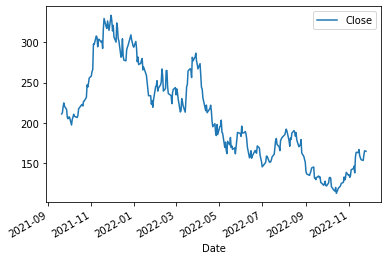

In [31]:
nvidia.iloc[-300:].plot.line(y='Close', use_index=True)

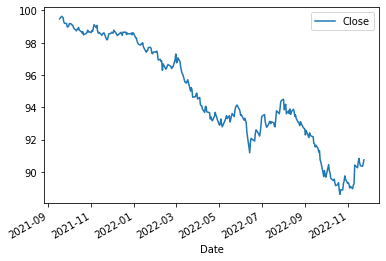

In [30]:
bitcoin.iloc[-300:].plot.line(y='Close', use_index=True)

In [8]:
del nvidia['Dividends']
del nvidia['Stock Splits']

In [9]:
nvidia['t1'] = nvidia['Close'].shift(-1)

In [10]:
nvidia

,Open,High,Low,Close,Volume,t1
Date,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.415963
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.383690
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.382495
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.381300
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.363370
...,...,...,...,...,...,...
2022-11-18 00:00:00-05:00,159.660004,160.020004,151.199997,154.089996,49167700.0,153.169998
2022-11-21 00:00:00-05:00,151.470001,154.770004,150.800003,153.169998,40473900.0,160.380005
2022-11-22 00:00:00-05:00,153.279999,160.580002,151.220001,160.380005,47286600.0,165.190002


In [44]:
nvidia['Target'] = (nvidia['t1'] > nvidia['Close']).astype(int)

In [ ]:
nvidia

,Open,High,Low,Close,Volume,t1,Target
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.415963,1
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.383690,0
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.382495,0
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.381300,0
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.363370,0
...,...,...,...,...,...,...,...
2022-11-17 00:00:00-05:00,157.149994,162.660004,155.350006,156.770004,71089400.0,154.089996,0
2022-11-18 00:00:00-05:00,159.660004,160.020004,151.199997,154.089996,49167700.0,153.169998,0
2022-11-21 00:00:00-05:00,151.470001,154.770004,150.800003,153.169998,40473900.0,160.380005,1


In [32]:
bitcoin.rename(columns = {'Close': 'Close_B', 'High': 'High_B', 'Low': 'Low_B', 
                       'Adj Close': 'Adj Close_B', 'Volume': 'Volume_B', 'Open': 'Open_B'}, 
            inplace = True)

In [34]:
del bitcoin['Dividends']
del bitcoin['Stock Splits']

In [35]:
bitcoin

,Open_B,High_B,Low_B,Close_B,Volume_B
Date,,,,,
2020-10-01 00:00:00-04:00,100.000000,100.000000,100.000000,100.000000,0
2020-10-02 00:00:00-04:00,100.000000,100.000000,100.000000,100.000000,0
2020-10-05 00:00:00-04:00,100.029999,100.040001,99.995003,99.995003,10725
2020-10-06 00:00:00-04:00,100.010002,100.029999,100.010002,100.029999,10080
2020-10-07 00:00:00-04:00,99.949997,99.959999,99.919998,99.919998,6350
...,...,...,...,...,...
2022-11-17 00:00:00-05:00,90.481300,90.595001,90.481300,90.565300,458
2022-11-18 00:00:00-05:00,90.385498,90.385498,90.385498,90.385498,2
2022-11-21 00:00:00-05:00,90.540001,90.540001,90.344902,90.344902,6309


In [ ]:
def smooth_data(data, alpha):
  return data.ewm(alpha=alpha).mean()

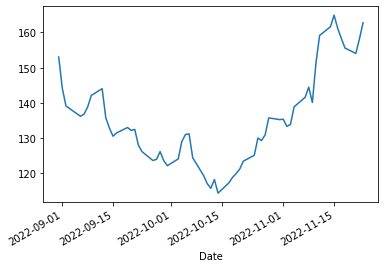

In [ ]:
alpha = 0.65
data = smooth_data(nvidia, alpha)

smooth_trend = data.iloc[-60:]
smooth_trend['Close'].plot()

In [ ]:
data.rename(columns = {'Close': 'close', 'High': 'high', 'Low': 'low', 
                       'Adj Close': 'adj close', 'Volume': 'volume', 'Open': 'open'}, 
            inplace = True)

In [ ]:
indicators = ['OBV', 'ADL', 'ADX', 'RSI', 'STOCH', 'SMA']

In [ ]:
indicators = ['RSI', 'STOCH', 'ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV']

In [ ]:
indicators = ['SMA', 'SMM', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'TRIX', 'VAMA', 'ER', 'KAMA', 
             'ZLEMA', 'WMA', 'HMA', 'EVWMA', 'VWAP', 'SMMA', 'MOM', 'ROC', 'RSI', 'IFT_RSI']

In [ ]:
for indicator in indicators:
  data[indicator] = eval('TA.' + indicator + '(data)')

In [ ]:
print(data.columns)

Index(['open', 'high', 'low', 'close', 'volume', 't1', 'Target', 'OBV', 'ADL',
       'ADX', 'RSI', 'STOCH', 'SMA'],
      dtype='object')


In [ ]:
print(nvidia.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'Target'], dtype='object')


In [ ]:
to_del = ['open', 'high', 'low', 'close', 'volume', 't1', 'Target']

In [ ]:
for column in to_del:
  del data[column]

In [ ]:
nvidia = nvidia.merge(data, how='inner', on='Date')

In [ ]:
nvidia = nvidia.fillna(0)

In [ ]:
nvidia

,Open,High,Low,Close,Volume,t1,Target,OBV,ADL,ADX,RSI,STOCH,SMA
Date,,,,,,,,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.415963,1,0.000000e+00,-1.516011e+08,0.000000,0.000000,0.000000,0.000000
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.383690,0,1.081941e+08,-1.279991e+08,0.000000,100.000000,0.000000,0.000000
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.382495,0,5.016919e+07,-1.529518e+08,0.000000,64.439875,0.000000,0.000000
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.381300,0,1.430915e+07,-1.557690e+08,0.000000,56.547007,0.000000,0.000000
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.363370,0,-1.298567e+07,-1.586618e+08,0.000000,53.180767,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17 00:00:00-05:00,157.149994,162.660004,155.350006,156.770004,71089400.0,154.089996,0,1.987030e+10,4.293215e+09,35.498921,68.019938,74.548778,131.934418
2022-11-18 00:00:00-05:00,159.660004,160.020004,151.199997,154.089996,49167700.0,153.169998,0,1.981462e+10,4.270540e+09,35.336431,64.067135,67.166583,132.606436
2022-11-21 00:00:00-05:00,151.470001,154.770004,150.800003,153.169998,40473900.0,160.380005,1,1.976883e+10,4.265038e+09,34.846239,61.864992,62.967712,133.285704


In [38]:
nvidia = nvidia.iloc[-542:].merge(bitcoin, how='inner', on='Date')

In [45]:
nvidia

,Open,High,Low,Close,Volume,t1,Open_B,High_B,Low_B,Close_B,Volume_B,Target
Date,,,,,,,,,,,,
2020-10-02 00:00:00-04:00,132.005938,134.945511,130.269144,130.381439,55249600.0,136.173233,100.000000,100.000000,100.000000,100.000000,0,1
2020-10-05 00:00:00-04:00,132.115732,136.190703,131.983470,136.173233,47982000.0,137.111465,100.029999,100.040001,99.995003,99.995003,10725,1
2020-10-06 00:00:00-04:00,138.044737,141.158974,136.397774,137.111465,78442000.0,139.382263,100.010002,100.029999,100.010002,100.029999,10080,1
2020-10-07 00:00:00-04:00,139.739102,140.931903,138.379113,139.382263,41808400.0,138.132095,99.949997,99.959999,99.919998,99.919998,6350,0
2020-10-08 00:00:00-04:00,140.490238,140.585064,137.326090,138.132095,37890000.0,137.373474,99.989998,99.995003,99.971703,99.995003,650,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17 00:00:00-05:00,157.149994,162.660004,155.350006,156.770004,71089400.0,154.089996,90.481300,90.595001,90.481300,90.565300,458,0
2022-11-18 00:00:00-05:00,159.660004,160.020004,151.199997,154.089996,49167700.0,153.169998,90.385498,90.385498,90.385498,90.385498,2,0
2022-11-21 00:00:00-05:00,151.470001,154.770004,150.800003,153.169998,40473900.0,160.380005,90.540001,90.540001,90.344902,90.344902,6309,1


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from numpy.core.arrayprint import format_float_scientific
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [41]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [ ]:
# nvidia = nvidia.drop('2001-09-12 00:00:00-04:00')

In [46]:
print(nvidia.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'Open_B', 'High_B',
       'Low_B', 'Close_B', 'Volume_B', 'Target'],
      dtype='object')


In [43]:
print(len(nvidia))

541


In [50]:
train = nvidia.iloc[:-50]
test = nvidia.iloc[-50:]

predictors = ['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'Open_B', 'High_B',
       'Low_B', 'Close_B', 'Volume_B']

model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [49]:
train = nvidia.iloc[:-100]
test = nvidia.iloc[-100:]

predictors = ['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'SMA', 'SMM', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 
              'TRIX', 'VAMA', 'ER', 'KAMA', 'ZLEMA', 'WMA', 'HMA', 'EVWMA', 'VWAP', 'SMMA', 'MOM', 'ROC', 'RSI', 'IFT_RSI']

model.fit(train[predictors], train['Target'])

KeyError: ignored

In [51]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)

In [52]:
precision_score(test['Target'], preds)

0.6666666666666666

In [53]:
combined = pd.concat([test['Target'], preds], axis=1)

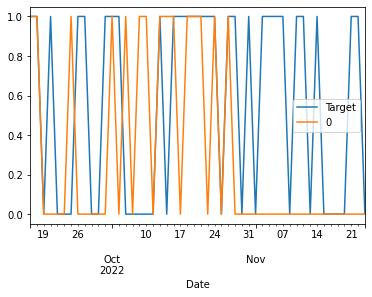

In [54]:
combined.plot()

In [55]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index = test.index, name = 'Predictions')
  combined = pd.concat([test['Target'], preds], axis = 1)
  return combined

In [56]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i + step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [57]:
predictions = backtest(nvidia, model, predictors)

ValueError: ignored

In [ ]:
predictions['Predictions'].value_counts()

0    2268
1    1234
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

0.6126878130217028

In [ ]:
predictions['Target'].value_counts() / predictions.shape[0]

In [ ]:
horizons = [2, 5, 60, 250, 1000]

In [ ]:
new_predictors = []

for horizon in horizons:
  rolling_averages = nvidia.rolling(horizon).mean()

  ratio_column = f'Close_Ratio_{horizon}'
  nvidia[ratio_column] = nvidia['Close'] / rolling_averages['Close']

  trend_column = f'Trend_{horizon}'
  nvidia[trend_column] = nvidia.shift(1).rolling(horizon).sum()['Target']

  new_predictors += [ratio_column, trend_column]

In [ ]:
# nvidia = nvidia.dropna()
nvidia = nvidia.fillna(0)

In [ ]:
nvidia

,Open,High,Low,Close,Volume,t1,Target,OBV,ADL,ADX,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.415963,1,0.000000e+00,-1.516011e+08,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.383690,0,1.081941e+08,-1.279991e+08,0.000000,...,1.049774,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.382495,0,5.016919e+07,-1.529518e+08,0.000000,...,0.959642,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.381300,0,1.430915e+07,-1.557690e+08,0.000000,...,0.998440,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.363370,0,-1.298567e+07,-1.586618e+08,0.000000,...,0.998435,0.0,0.982748,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17 00:00:00-05:00,157.149994,162.660004,155.350006,156.770004,71089400.0,154.089996,0,1.987030e+10,4.293215e+09,35.498921,...,0.992624,0.0,0.969212,2.0,1.157441,31.0,0.777247,121.0,1.227416,540.0
2022-11-18 00:00:00-05:00,159.660004,160.020004,151.199997,154.089996,49167700.0,153.169998,0,1.981462e+10,4.270540e+09,35.336431,...,0.991379,0.0,0.963580,1.0,1.141163,30.0,0.766471,121.0,1.205347,540.0
2022-11-21 00:00:00-05:00,151.470001,154.770004,150.800003,153.169998,40473900.0,160.380005,1,1.976883e+10,4.265038e+09,34.846239,...,0.997006,0.0,0.969688,1.0,1.135665,30.0,0.764390,121.0,1.197096,539.0


In [ ]:
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
names = [
    # "SVC",
    #"Linear Regression",
    "Random Forest",
    "Ada Boost",
    "Decision Tree",
    "Quadratic Discrimination",
    "MPLC"
]

classifiers = [
    #svm.SVC(gamma=0.001, C=100., kernel='rbf', verbose=False, probability=False),
    #LinearRegression(),
    RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1),
    AdaBoostClassifier(),
    DecisionTreeClassifier(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(alpha=1, max_iter=1000)
]

In [ ]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= .6] = 1
  preds[preds < .6] = 0
  preds = pd.Series(preds, index = test.index, name = 'Predictions')
  combined = pd.concat([test['Target'], preds], axis = 1)
  return combined

In [ ]:
accuracy = []
for model in classifiers:
  predictions = backtest(nvidia, model, new_predictors)
  accuracy.append(precision_score(predictions['Target'], predictions['Predictions']))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for name, value in zip(names, accuracy):
  print('Classifier: {}, Accuracy: {}'.format(name, value))

Classifier: Random Forest, Accuracy: 0.573170731707317
Classifier: Ada Boost, Accuracy: 0.0
Classifier: Decision Tree, Accuracy: 0.5340760157273918
Classifier: Quadratic Discrimination, Accuracy: 0.5277945619335347
Classifier: MPLC, Accuracy: 0.5427789185489391


Tried differnt classifiers but still fucking low -> to improve

In [ ]:
predictions = backtest(nvidia, model, new_predictors)

In [ ]:
predictions['Predictions'].value_counts()

0.0    2348
1.0    1154
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5142083897158322